# Crop the NLCD with point cloud boundaries 

# import libraries

In [1]:
import geopandas as gpd
from shapely.geometry import Polygon, mapping, MultiPolygon, box
import os
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
import requests
from colorama import Fore, Style
import numpy as np
import time
from datetime import datetime
import re
from glob import glob

# functions 

In [2]:
def extract_last_year_from_string(input_string):
    """
    Extracts the last year in the format "2XXX" from a string, where the year is preceded by either "_" or "-".

    Parameters:
    input_string (str): The input string containing various substrings.

    Returns:
    str: The last extracted year or None if no year is found.
    """
    # Define regular expression pattern for years preceded by "_" or "-"
    pattern = re.compile(r'[_-](20\d{2})')
    
    # Find all matches in the input string
    matches = pattern.findall(input_string)
    
    # Return the last match if there are any matches
    return int(matches[-1]) if matches else -1

def find_closest_year(target_year, years_list):
    """
    Finds the closest year to the target year from a list of years.

    Parameters:
    target_year (int): The target year.
    years_list (list of int): The list of years to search through.

    Returns:
    int: The closest year to the target year.
    """
    # Ensure the years_list is not empty
    if not years_list:
        raise ValueError("The list of years is empty.")
    
    # Find the closest year
    closest_year = min(years_list, key=lambda year: abs(year - target_year))
    return closest_year


def clip_raster_with_named_polygons(raster_path, polygons_gdf, output_dir, nlcd_year):
    """
    Clips a raster file using a GeoDataFrame of polygons and saves the clipped rasters with names.

    Parameters:
    raster_path (str): The path to the raster file.
    polygons_gdf (GeoDataFrame): The GeoDataFrame containing the polygons.
    output_dir (str): The directory to save the clipped rasters.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    error_message = []
    # Open the raster
    with rasterio.open(raster_path) as src:
        raster_crs = src.crs

        # Reproject polygons to the raster's CRS
        polygons_gdf = polygons_gdf.to_crs(raster_crs)
        for i, (_, polygon) in enumerate(polygons_gdf.iterrows()):
            try: 
                poly_name = polygon['name']
                print(polygon['name'])
                # if polygon['name'][:2] == 'AK': # alaska
                #     print('  skip')
                #     continue
                # Convert the polygon to GeoJSON format
                geom = [mapping(polygon['geometry'])]
                
                # Clip the raster with the polygon
                out_image, out_transform = mask(src, geom, crop=True)
                
                # Update the metadata
                out_meta = src.meta.copy()
                out_meta.update({
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform,
                    "compress": "deflate"
                })
                
                # Get the name attribute for the file name
                polygon_name = polygon['name'].replace(" ", "_")  # Replace spaces with underscores for the file name
                out_raster_path = os.path.join(output_dir, f"{polygon_name}_nlcd_{nlcd_year}.tif")
                
                # Save the clipped raster
                with rasterio.open(out_raster_path, "w", **out_meta) as dest:
                    dest.write(out_image)
                print(f"Saved clipped raster: {out_raster_path}")
                # break 
            except Exception as e:
                message = f'Exception occured at {poly_name}: {e}'
                error_message.append(message)
                print(f'Exception occured at {poly_name}: {e}')
                # print(f'skipped: {polygon['name']}')
                continue
    return error_message

def visualize_raster(raster_path):
    """
    Reads and visualizes a raster file.

    Parameters:
    raster_path (str): The path to the raster file.
    """
    # Open the raster file
    with rasterio.open(raster_path) as src:
        # Read the data
        raster_data = src.read()
        print(src.crs)
        print(np.unique(raster_data))
        # Plot the data
        plt.figure(figsize=(10, 10))
        # Check the number of bands
        if raster_data.shape[0] == 1:
            # Single-band raster
            show(raster_data, transform=src.transform, cmap='gray')
        elif raster_data.shape[0] == 3:
            # RGB raster
            show(raster_data, transform=src.transform)
        else:
            # Multiband raster, display the first band
            show(raster_data[0], transform=src.transform, cmap='gray')
        
        plt.title(f"Raster visualization of {raster_path}")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()  

# Cropping

In [3]:
# read the boundary file
boundary = gpd.read_file('../../data/point_cloud_boundary/20240627.topojson')

# augment the boundary dataset with the Lidar captured year
years = []
for i, name in enumerate(boundary.name.values):
    years.append(extract_last_year_from_string(name))
boundary['capture_year'] = years 

# get corresponding NLCD years for each LIDAR data 
nlcd_epochs = [2001, 2004, 2006, 2008, 2011, 2013, 2016, 2019, 2021]
lidar_years = boundary.capture_year.values # array of years 
closest_NLCD_years = [find_closest_year(x, nlcd_epochs) for x in lidar_years]
boundary['closest_nlcd_year'] = closest_NLCD_years
boundary

,id,count,name,url,geometry,capture_year,closest_nlcd_year
0,0,529285317,AK_BrooksCamp_2012,https://s3-us-west-2.amazonaws.com/usgs-lidar-...,"MULTIPOLYGON (((-155.62735 58.46319, -155.6004...",2012,2011
1,1,55711772,AK_Coastal_2009,https://s3-us-west-2.amazonaws.com/usgs-lidar-...,"MULTIPOLYGON (((-141.27766 69.60296, -141.2282...",2009,2008
2,2,19036249620,AK_DeltaJunction_1_2021,https://s3-us-west-2.amazonaws.com/usgs-lidar-...,"MULTIPOLYGON (((-144.72793 63.62868, -144.7099...",2021,2021
3,3,1266097458,AK_Fairbanks-NSBorough_2010,https://s3-us-west-2.amazonaws.com/usgs-lidar-...,"MULTIPOLYGON (((-147.30828 64.70559, -147.2543...",2010,2011
4,4,23016813926,AK_GlacierBay_4_2019,https://s3-us-west-2.amazonaws.com/usgs-lidar-...,"MULTIPOLYGON (((-136.64027 58.18359, -136.6133...",2019,2019
...,...,...,...,...,...,...,...
2113,2113,5306053,WY_YellowstoneNP_1RF_2020,https://s3-us-west-2.amazonaws.com/usgs-lidar-...,"MULTIPOLYGON (((-110.48184 45.16577, -110.4638...",2020,2019
2114,2114,24675784264,WY_YellowstoneNP_1_2020,https://s3-us-west-2.amazonaws.com/usgs-lidar-...,"MULTIPOLYGON (((-109.97566 44.99592, -109.9262...",2020,2019
2115,2115,16982933,WY_YellowstoneNP_2RF_2020,https://s3-us-west-2.amazonaws.com/usgs-lidar-...,"MULTIPOLYGON (((-110.80605 44.81651, -110.8015...",2020,2019
2116,2116,183753966673,WY_YellowstoneNP_2_2020,https://s3-us-west-2.amazonaws.com/usgs-lidar-...,"MULTIPOLYGON (((-110.31595 44.51519, -110.2979...",2020,2019


## Crop point clouds with closest_nlcd_year = 2001 ~ 2021 

In [38]:
nlcd_year = 2001

selected = boundary.closest_nlcd_year == nlcd_year
gdf = boundary[selected]

raster_path = f'../../data/NLCD_all/nlcd_{nlcd_year}_land_cover_l48_20210604.img'
output_dir = '../../data/NLCD_clip/'

# Load the polygons into a GeoDataFrame
gdf = gdf.set_crs(epsg=4326, inplace=False)

clip_raster_with_named_polygons(raster_path, gdf, output_dir, nlcd_year=nlcd_year)

AK_NativeAKVillages_1_D22
Exception occured at AK_NativeAKVillages_1_D22: Input shapes do not overlap raster.
AK_NativeAKVillages_2_D22
Exception occured at AK_NativeAKVillages_2_D22: Input shapes do not overlap raster.
AK_NativeAKVillages_3_D22
Exception occured at AK_NativeAKVillages_3_D22: Input shapes do not overlap raster.
AK_NativeAKVillages_4_D22
Exception occured at AK_NativeAKVillages_4_D22: Input shapes do not overlap raster.
AK_NativeAKVillages_5_D22
Exception occured at AK_NativeAKVillages_5_D22: Input shapes do not overlap raster.
AK_NativeAKVillages_6_D22
Exception occured at AK_NativeAKVillages_6_D22: Input shapes do not overlap raster.
AK_SELandslides_1_D22
Exception occured at AK_SELandslides_1_D22: Input shapes do not overlap raster.
AL_SWCentral_1_B22
Saved clipped raster: ../../data/NLCD_clip/AL_SWCentral_1_B22_nlcd_2001.tif
AZ_CenCoconino_1_B22
Saved clipped raster: ../../data/NLCD_clip/AZ_CenCoconino_1_B22_nlcd_2001.tif
AZ_CenCoconino_2_B22
Saved clipped raster: .

['Exception occured at AK_NativeAKVillages_1_D22: Input shapes do not overlap raster.',
 'Exception occured at AK_NativeAKVillages_2_D22: Input shapes do not overlap raster.',
 'Exception occured at AK_NativeAKVillages_3_D22: Input shapes do not overlap raster.',
 'Exception occured at AK_NativeAKVillages_4_D22: Input shapes do not overlap raster.',
 'Exception occured at AK_NativeAKVillages_5_D22: Input shapes do not overlap raster.',
 'Exception occured at AK_NativeAKVillages_6_D22: Input shapes do not overlap raster.',
 'Exception occured at AK_SELandslides_1_D22: Input shapes do not overlap raster.']

In [4]:
nlcd_year = 2004

selected = boundary.closest_nlcd_year == nlcd_year
gdf = boundary[selected]

raster_path = f'../../data/NLCD_all/nlcd_{nlcd_year}_land_cover_l48_20210604.img'
output_dir = '../../data/NLCD_clip/'

# Load the polygons into a GeoDataFrame
gdf = gdf.set_crs(epsg=4326, inplace=False)

clip_raster_with_named_polygons(raster_path, gdf, output_dir, nlcd_year=nlcd_year)

CA_Scripps-Apr_2004
Saved clipped raster: ../../data/NLCD_clip/CA_Scripps-Apr_2004_nlcd_2004.tif
CA_Scripps-Apr_2005
Saved clipped raster: ../../data/NLCD_clip/CA_Scripps-Apr_2005_nlcd_2004.tif
CA_Scripps-Mar_2003
Saved clipped raster: ../../data/NLCD_clip/CA_Scripps-Mar_2003_nlcd_2004.tif
CA_Scripps-Oct_2003
Saved clipped raster: ../../data/NLCD_clip/CA_Scripps-Oct_2003_nlcd_2004.tif
CA_Scripps-Oct_2005
Saved clipped raster: ../../data/NLCD_clip/CA_Scripps-Oct_2005_nlcd_2004.tif
CA_Scripps-Sep_2004
Saved clipped raster: ../../data/NLCD_clip/CA_Scripps-Sep_2004_nlcd_2004.tif
FL_FlaglerCo_2004
Saved clipped raster: ../../data/NLCD_clip/FL_FlaglerCo_2004_nlcd_2004.tif


[]

In [28]:
nlcd_year = 2006

selected = boundary.closest_nlcd_year == nlcd_year
gdf = boundary[selected]

raster_path = f'../../data/NLCD_all/nlcd_{nlcd_year}_land_cover_l48_20210604.img'
output_dir = '../../data/NLCD_clip/'

# Load the polygons into a GeoDataFrame
gdf = gdf.set_crs(epsg=4326, inplace=False)

clip_raster_with_named_polygons(raster_path, gdf, output_dir, nlcd_year=nlcd_year)

AK_ValdezB_2007
Exception occured at AK_ValdezB_2007: Input shapes do not overlap raster.
AK_Valdez_2007
Exception occured at AK_Valdez_2007: Input shapes do not overlap raster.
ARRA-IL_LakeCo_2007
Saved clipped raster: ../../data/NLCD_clip/ARRA-IL_LakeCo_2007_nlcd_2006.tif
CA_AlamedaCo_2006
Saved clipped raster: ../../data/NLCD_clip/CA_AlamedaCo_2006_nlcd_2006.tif
CA_ContraCostaCo_2007
Saved clipped raster: ../../data/NLCD_clip/CA_ContraCostaCo_2007_nlcd_2006.tif
CA_DayFire_2007
Saved clipped raster: ../../data/NLCD_clip/CA_DayFire_2007_nlcd_2006.tif
CA_Scripps-Mar_2006
Saved clipped raster: ../../data/NLCD_clip/CA_Scripps-Mar_2006_nlcd_2006.tif
FL_CharlotteCounty_2007
Saved clipped raster: ../../data/NLCD_clip/FL_CharlotteCounty_2007_nlcd_2006.tif
FL_ClayPutnam_2007
Saved clipped raster: ../../data/NLCD_clip/FL_ClayPutnam_2007_nlcd_2006.tif
FL_DuvalCo_2007
Saved clipped raster: ../../data/NLCD_clip/FL_DuvalCo_2007_nlcd_2006.tif
FL_EscambiaCo_2006
Saved clipped raster: ../../data/NLCD

['Exception occured at AK_ValdezB_2007: Input shapes do not overlap raster.',
 'Exception occured at AK_Valdez_2007: Input shapes do not overlap raster.']

In [29]:
nlcd_year = 2008

selected = boundary.closest_nlcd_year == nlcd_year
gdf = boundary[selected]

raster_path = f'../../data/NLCD_all/nlcd_{nlcd_year}_land_cover_l48_20210604.img'
output_dir = '../../data/NLCD_clip/'

# Load the polygons into a GeoDataFrame
gdf = gdf.set_crs(epsg=4326, inplace=False)

clip_raster_with_named_polygons(raster_path, gdf, output_dir, nlcd_year=nlcd_year)

AK_Coastal_2009
Exception occured at AK_Coastal_2009: Input shapes do not overlap raster.
AK_Kenai_2008
Exception occured at AK_Kenai_2008: Input shapes do not overlap raster.
AK_YukonFlats_2009
Exception occured at AK_YukonFlats_2009: Input shapes do not overlap raster.
AR_BuffaloRiver_2009
Saved clipped raster: ../../data/NLCD_clip/AR_BuffaloRiver_2009_nlcd_2008.tif
CO_DenverDNC_2008
Saved clipped raster: ../../data/NLCD_clip/CO_DenverDNC_2008_nlcd_2008.tif
CO_Denver_2008
Saved clipped raster: ../../data/NLCD_clip/CO_Denver_2008_nlcd_2008.tif
FL_Elgin_2006-2008
Saved clipped raster: ../../data/NLCD_clip/FL_Elgin_2006-2008_nlcd_2008.tif
FL_LeonCo_2009
Saved clipped raster: ../../data/NLCD_clip/FL_LeonCo_2009_nlcd_2008.tif
FL_OkaloosaCo_2008
Saved clipped raster: ../../data/NLCD_clip/FL_OkaloosaCo_2008_nlcd_2008.tif
FL_StJohnsCo_2008
Saved clipped raster: ../../data/NLCD_clip/FL_StJohnsCo_2008_nlcd_2008.tif
FL_WaltonAFB_2006-2008
Saved clipped raster: ../../data/NLCD_clip/FL_WaltonAFB_

['Exception occured at AK_Coastal_2009: Input shapes do not overlap raster.',
 'Exception occured at AK_Kenai_2008: Input shapes do not overlap raster.',
 'Exception occured at AK_YukonFlats_2009: Input shapes do not overlap raster.']

In [30]:
nlcd_year = 2011

selected = boundary.closest_nlcd_year == nlcd_year
gdf = boundary[selected]

raster_path = f'../../data/NLCD_all/nlcd_{nlcd_year}_land_cover_l48_20210604.img'
output_dir = '../../data/NLCD_clip/'

# Load the polygons into a GeoDataFrame
gdf = gdf.set_crs(epsg=4326, inplace=False)

clip_raster_with_named_polygons(raster_path, gdf, output_dir, nlcd_year=nlcd_year)

AK_BrooksCamp_2012
Exception occured at AK_BrooksCamp_2012: Input shapes do not overlap raster.
AK_Fairbanks-NSBorough_2010
Exception occured at AK_Fairbanks-NSBorough_2010: Input shapes do not overlap raster.
AK_Juneau_2012
Exception occured at AK_Juneau_2012: Input shapes do not overlap raster.
AK_MatanuskaSusitna-Lot1_2011
Exception occured at AK_MatanuskaSusitna-Lot1_2011: Input shapes do not overlap raster.
AK_MatanuskaSusitna-Lot2_2011
Exception occured at AK_MatanuskaSusitna-Lot2_2011: Input shapes do not overlap raster.
AK_NomeCreek_2010
Exception occured at AK_NomeCreek_2010: Input shapes do not overlap raster.
AL_BaldwinCo-East_2011
Saved clipped raster: ../../data/NLCD_clip/AL_BaldwinCo-East_2011_nlcd_2011.tif
AL_BaldwinCo-West_2011
Saved clipped raster: ../../data/NLCD_clip/AL_BaldwinCo-West_2011_nlcd_2011.tif
AL_BlountCo_2010
Saved clipped raster: ../../data/NLCD_clip/AL_BlountCo_2010_nlcd_2011.tif
AL_ColbertLauderdale_2011
Saved clipped raster: ../../data/NLCD_clip/AL_Col

['Exception occured at AK_BrooksCamp_2012: Input shapes do not overlap raster.',
 'Exception occured at AK_Fairbanks-NSBorough_2010: Input shapes do not overlap raster.',
 'Exception occured at AK_Juneau_2012: Input shapes do not overlap raster.',
 'Exception occured at AK_MatanuskaSusitna-Lot1_2011: Input shapes do not overlap raster.',
 'Exception occured at AK_MatanuskaSusitna-Lot2_2011: Input shapes do not overlap raster.',
 'Exception occured at AK_NomeCreek_2010: Input shapes do not overlap raster.',
 'Exception occured at ARRA-AK_EkluntaGlacier_2010: Input shapes do not overlap raster.',
 'Exception occured at Guam_2012: Input shapes do not overlap raster.',
 'Exception occured at UT_Ogden-FEMA_2011: Input shapes do not overlap raster.']

In [31]:
nlcd_year = 2013

selected = boundary.closest_nlcd_year == nlcd_year
gdf = boundary[selected]

raster_path = f'../../data/NLCD_all/nlcd_{nlcd_year}_land_cover_l48_20210604.img'
output_dir = '../../data/NLCD_clip/'

# Load the polygons into a GeoDataFrame
gdf = gdf.set_crs(epsg=4326, inplace=False)

clip_raster_with_named_polygons(raster_path, gdf, output_dir, nlcd_year=nlcd_year)

AZ_SanCarlosReservation_2013
Saved clipped raster: ../../data/NLCD_clip/AZ_SanCarlosReservation_2013_nlcd_2013.tif
CA_SanDiegoQL2_2014
Saved clipped raster: ../../data/NLCD_clip/CA_SanDiegoQL2_2014_nlcd_2013.tif
FL_SuwanneeRiver-Area1_2013
Saved clipped raster: ../../data/NLCD_clip/FL_SuwanneeRiver-Area1_2013_nlcd_2013.tif
FL_SuwanneeRiver-Area2_2013
Saved clipped raster: ../../data/NLCD_clip/FL_SuwanneeRiver-Area2_2013_nlcd_2013.tif
FL_SuwanneeRiver-Area3_2013
Saved clipped raster: ../../data/NLCD_clip/FL_SuwanneeRiver-Area3_2013_nlcd_2013.tif
FL_SuwanneeRiver-Area4_2013
Saved clipped raster: ../../data/NLCD_clip/FL_SuwanneeRiver-Area4_2013_nlcd_2013.tif
FL_SuwanneeRiver-FY12-Area4-5_2013
Saved clipped raster: ../../data/NLCD_clip/FL_SuwanneeRiver-FY12-Area4-5_2013_nlcd_2013.tif
FL_SuwanneeRiver_2013
Saved clipped raster: ../../data/NLCD_clip/FL_SuwanneeRiver_2013_nlcd_2013.tif
IL_FordIroquoisLivingston_L1_2014
Saved clipped raster: ../../data/NLCD_clip/IL_FordIroquoisLivingston_L1_20

[]

In [32]:
nlcd_year = 2016

selected = boundary.closest_nlcd_year == nlcd_year
gdf = boundary[selected]

raster_path = f'../../data/NLCD_all/nlcd_{nlcd_year}_land_cover_l48_20210604.img'
output_dir = '../../data/NLCD_clip/'

# Load the polygons into a GeoDataFrame
gdf = gdf.set_crs(epsg=4326, inplace=False)

clip_raster_with_named_polygons(raster_path, gdf, output_dir, nlcd_year=nlcd_year)

AL_25Co_TL_2017
Saved clipped raster: ../../data/NLCD_clip/AL_25Co_TL_2017_nlcd_2016.tif
AZ_FEMA_Central_2017
Saved clipped raster: ../../data/NLCD_clip/AZ_FEMA_Central_2017_nlcd_2016.tif
AZ_FEMA_East_2017
Saved clipped raster: ../../data/NLCD_clip/AZ_FEMA_East_2017_nlcd_2016.tif
CA_SE_Fault_Zone_2017
Saved clipped raster: ../../data/NLCD_clip/CA_SE_Fault_Zone_2017_nlcd_2016.tif
CA_SanDiego_2015_C17_1
Saved clipped raster: ../../data/NLCD_clip/CA_SanDiego_2015_C17_1_nlcd_2016.tif
CT_Statewide_B1_2016
Saved clipped raster: ../../data/NLCD_clip/CT_Statewide_B1_2016_nlcd_2016.tif
CT_Statewide_B2_2016
Saved clipped raster: ../../data/NLCD_clip/CT_Statewide_B2_2016_nlcd_2016.tif
CT_Statewide_B3_2016
Saved clipped raster: ../../data/NLCD_clip/CT_Statewide_B3_2016_nlcd_2016.tif
CT_Statewide_B4_2016
Saved clipped raster: ../../data/NLCD_clip/CT_Statewide_B4_2016_nlcd_2016.tif
CT_Statewide_B5_2016
Saved clipped raster: ../../data/NLCD_clip/CT_Statewide_B5_2016_nlcd_2016.tif
CT_Statewide_B6_2016

['Exception occured at HI_Hawaii_Island_2017: Input shapes do not overlap raster.',
 'Exception occured at USGS_LPC_AK_Anchorage_2015_LAS_2017: Input shapes do not overlap raster.',
 'Exception occured at USGS_LPC_HI_Oahu_2012_LAS_2015: Input shapes do not overlap raster.',
 'Exception occured at USGS_LPC_PR_PuertoRico_2016_LAS_2017: Input shapes do not overlap raster.']

In [33]:
nlcd_year = 2019

selected = boundary.closest_nlcd_year == nlcd_year
gdf = boundary[selected]

raster_path = f'../../data/NLCD_all/nlcd_{nlcd_year}_land_cover_l48_20210604.img'
output_dir = '../../data/NLCD_clip/'

# Load the polygons into a GeoDataFrame
gdf = gdf.set_crs(epsg=4326, inplace=False)

clip_raster_with_named_polygons(raster_path, gdf, output_dir, nlcd_year=nlcd_year)

AK_GlacierBay_4_2019
Exception occured at AK_GlacierBay_4_2019: Input shapes do not overlap raster.
AK_GlacierBay_B3_2019
Exception occured at AK_GlacierBay_B3_2019: Input shapes do not overlap raster.
AK_MatSuBorough_B1_2019
Exception occured at AK_MatSuBorough_B1_2019: Input shapes do not overlap raster.
AK_MatSuBorough_B2_2019
Exception occured at AK_MatSuBorough_B2_2019: Input shapes do not overlap raster.
AK_NorthSlope_B10_2018
Exception occured at AK_NorthSlope_B10_2018: Input shapes do not overlap raster.
AK_NorthSlope_B11_2018
Exception occured at AK_NorthSlope_B11_2018: Input shapes do not overlap raster.
AK_NorthSlope_B12_2018
Exception occured at AK_NorthSlope_B12_2018: Input shapes do not overlap raster.
AK_NorthSlope_B13_2018
Exception occured at AK_NorthSlope_B13_2018: Input shapes do not overlap raster.
AK_NorthSlope_B14_2018
Exception occured at AK_NorthSlope_B14_2018: Input shapes do not overlap raster.
AK_NorthSlope_B1_2018
Exception occured at AK_NorthSlope_B1_2018: 

['Exception occured at AK_GlacierBay_4_2019: Input shapes do not overlap raster.',
 'Exception occured at AK_GlacierBay_B3_2019: Input shapes do not overlap raster.',
 'Exception occured at AK_MatSuBorough_B1_2019: Input shapes do not overlap raster.',
 'Exception occured at AK_MatSuBorough_B2_2019: Input shapes do not overlap raster.',
 'Exception occured at AK_NorthSlope_B10_2018: Input shapes do not overlap raster.',
 'Exception occured at AK_NorthSlope_B11_2018: Input shapes do not overlap raster.',
 'Exception occured at AK_NorthSlope_B12_2018: Input shapes do not overlap raster.',
 'Exception occured at AK_NorthSlope_B13_2018: Input shapes do not overlap raster.',
 'Exception occured at AK_NorthSlope_B14_2018: Input shapes do not overlap raster.',
 'Exception occured at AK_NorthSlope_B1_2018: Input shapes do not overlap raster.',
 'Exception occured at AK_NorthSlope_B2_2018: Input shapes do not overlap raster.',
 'Exception occured at AK_NorthSlope_B3_2018: Input shapes do not ov

In [37]:
nlcd_year = 2021

selected = boundary.closest_nlcd_year == nlcd_year
gdf = boundary[selected]

raster_path = f'../../data/NLCD_all/nlcd_{nlcd_year}_land_cover_l48_20230630.img'
output_dir = '../../data/NLCD_clip/'

# Load the polygons into a GeoDataFrame
gdf = gdf.set_crs(epsg=4326, inplace=False)

clip_raster_with_named_polygons(raster_path, gdf, output_dir, nlcd_year=nlcd_year)

AK_DeltaJunction_1_2021
Exception occured at AK_DeltaJunction_1_2021: Input shapes do not overlap raster.
AL_CofDalGenEsc_1_2021
Saved clipped raster: ../../data/NLCD_clip/AL_CofDalGenEsc_1_2021_nlcd_2021.tif
AZ_BlackRockGoodwin_1_2021
Saved clipped raster: ../../data/NLCD_clip/AZ_BlackRockGoodwin_1_2021_nlcd_2021.tif
AZ_MohaveCo_1_2021
Saved clipped raster: ../../data/NLCD_clip/AZ_MohaveCo_1_2021_nlcd_2021.tif
AZ_MohaveCo_2_2021
Saved clipped raster: ../../data/NLCD_clip/AZ_MohaveCo_2_2021_nlcd_2021.tif
AZ_PimaCo_1_2021
Saved clipped raster: ../../data/NLCD_clip/AZ_PimaCo_1_2021_nlcd_2021.tif
AZ_PimaCo_2_2021
Saved clipped raster: ../../data/NLCD_clip/AZ_PimaCo_2_2021_nlcd_2021.tif
AZ_Yavapai_1_2021
Saved clipped raster: ../../data/NLCD_clip/AZ_Yavapai_1_2021_nlcd_2021.tif
AZ_Yavapai_2_2021
Saved clipped raster: ../../data/NLCD_clip/AZ_Yavapai_2_2021_nlcd_2021.tif
CA_AlamedaCo_1_2021
Saved clipped raster: ../../data/NLCD_clip/CA_AlamedaCo_1_2021_nlcd_2021.tif
CA_AlamedaCo_2_2021
Saved

['Exception occured at AK_DeltaJunction_1_2021: Input shapes do not overlap raster.']

# validation

PROJCS["Albers Conical Equal Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
[ 0 11 21 22 23 24 31 41 42 43 52 71 81 82 90 95]


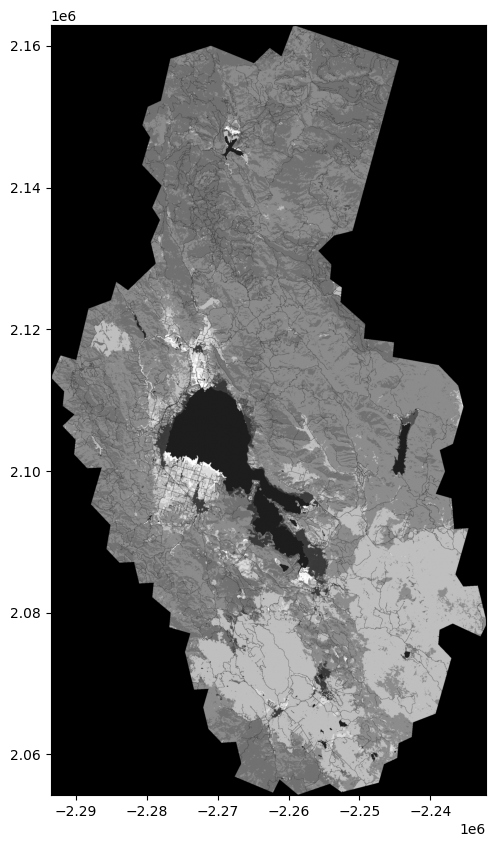

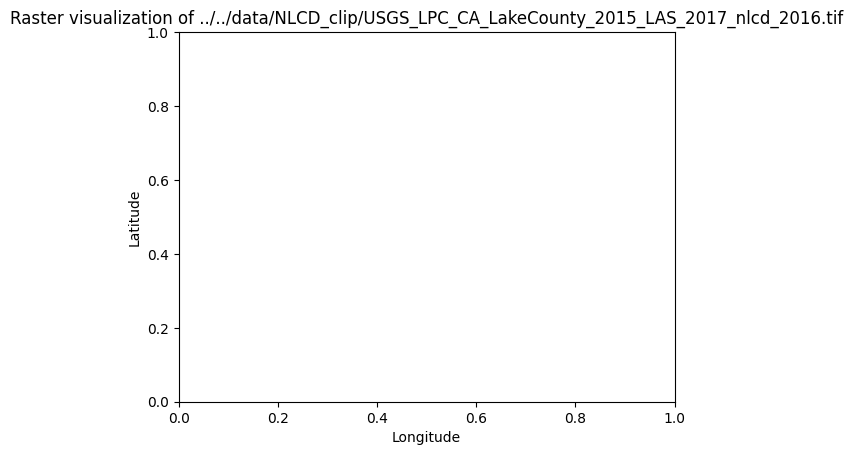

In [5]:
# validation
from glob import glob
rasters = glob('../../data/NLCD_clip/*.tif')
raster_path = rasters[np.random.randint(low=0, high=len(rasters))]
visualize_raster(raster_path)